In [1]:
import pandas as pd
import os
import shutil
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
from IPython.display import display, Audio
import librosa
import librosa.display
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Korisnik\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


In [10]:
#dividing to test, validation and training set
DATASET_AUDIO_PATH = "Data/genres_original/"

class_names = os.listdir(DATASET_AUDIO_PATH)
print("Our class names: {}".format(class_names,))

SHUFFLE_SEED = 43
VALID_and_TEST_SPLIT = 0.2
VALID_SPLIT = 0.5


BATCH_SIZE = 128
EPOCHS = 100
SAMPLING_RATE = 16000

audio_paths = [] # list of paths for every audio sample
labels = [] # classification
features = []

def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type="kaiser_fast")
        #augmentation, siffting
        pitch_shift_audio= librosa.effects.pitch_shift(audio, sample_rate,n_steps=3)
        mfccs = librosa.feature.mfcc(y=pitch_shift_audio, n_mfcc=40)
        mfccscaled = np.mean(mfccs.T, axis=0)     
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None
  
    return mfccscaled

for index, name in enumerate(class_names):
    dir_path = Path(DATASET_AUDIO_PATH)/name
    for filepath in os.listdir(dir_path):
        if filepath.endswith(".wav"):
            data = extract_features(os.path.join(dir_path, filepath))
            features.append([None, data, name])


features_df = pd.DataFrame(features, columns=["file", "feature", "class_label"])

Our class names: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [11]:
#print(features_df)
from sklearn import preprocessing
# 80:10:10
# Split into training, validation and test
X = np.array(features_df.feature.tolist())
y = np.array(features_df.class_label.tolist())

le = LabelEncoder()
yy = le.fit_transform(y)

x_train, x_test_valid, y_train, y_test_valid = train_test_split(X, yy, test_size=0.2, shuffle=True, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_test_valid,  y_test_valid, test_size=0.5, shuffle=True, random_state=42)
# scaler = preprocessing.StandardScaler().fit(x_train)
# x_train = scaler.transform(x_train)

# scaler1 = preprocessing.StandardScaler().fit(x_test)
# x_test = scaler1.transform(x_test)


# scaler2 = preprocessing.StandardScaler().fit(x_valid)
# x_valid = scaler2.transform(x_valid)


In [12]:
# model

from keras.models import Sequential
from keras.layers import Dense,BatchNormalization, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.utils import to_categorical


num_classes = 10
y_train = to_categorical(y_train, num_classes=num_classes)
y_valid = to_categorical(y_valid, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

model = Sequential()

model.add(Dense(128, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(num_classes, activation='softmax'))
model.build()
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')


In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               5248      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)               

In [14]:
from keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 100
batch_size = 16

checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=1, save_best_only=True)

start = datetime.now()

H = model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(x_valid, y_valid), 
          callbacks=[checkpointer], verbose=1)


train_score = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: ", train_score[1])

valid_score = model.evaluate(x_valid, y_valid, verbose=1)
print("Valid Accuracy: ", valid_score[1])




Train on 800 samples, validate on 100 samples
Epoch 1/100
800/800 [==============================] - 1s 938us/step - loss: 10.2822 - accuracy: 0.1050 - val_loss: 2.2867 - val_accuracy: 0.1400

Epoch 00001: val_loss improved from inf to 2.28668, saving model to best_weights.hdf5
Epoch 2/100
800/800 [==============================] - 0s 259us/step - loss: 3.7009 - accuracy: 0.1275 - val_loss: 2.1782 - val_accuracy: 0.2300

Epoch 00002: val_loss improved from 2.28668 to 2.17817, saving model to best_weights.hdf5
Epoch 3/100
800/800 [==============================] - 0s 263us/step - loss: 2.8154 - accuracy: 0.1437 - val_loss: 2.2830 - val_accuracy: 0.0500

Epoch 00003: val_loss did not improve from 2.17817
Epoch 4/100
800/800 [==============================] - 0s 270us/step - loss: 2.5027 - accuracy: 0.1538 - val_loss: 2.2600 - val_accuracy: 0.0900

Epoch 00004: val_loss did not improve from 2.17817
Epoch 5/100
800/800 [==============================] - 0s 265us/step - loss: 2.3617 - accur

800/800 [==============================] - 0s 121us/step - loss: 1.4684 - accuracy: 0.4875 - val_loss: 1.4660 - val_accuracy: 0.4500

Epoch 00038: val_loss improved from 1.46878 to 1.46604, saving model to best_weights.hdf5
Epoch 39/100
800/800 [==============================] - 0s 260us/step - loss: 1.4081 - accuracy: 0.5088 - val_loss: 1.4737 - val_accuracy: 0.5100

Epoch 00039: val_loss did not improve from 1.46604
Epoch 40/100
800/800 [==============================] - 0s 249us/step - loss: 1.4240 - accuracy: 0.5113 - val_loss: 1.5033 - val_accuracy: 0.4800

Epoch 00040: val_loss did not improve from 1.46604
Epoch 41/100
800/800 [==============================] - 0s 263us/step - loss: 1.4088 - accuracy: 0.4975 - val_loss: 1.5268 - val_accuracy: 0.4400

Epoch 00041: val_loss did not improve from 1.46604
Epoch 42/100
800/800 [==============================] - 0s 252us/step - loss: 1.3370 - accuracy: 0.5113 - val_loss: 1.5096 - val_accuracy: 0.4600

Epoch 00042: val_loss did not impro

800/800 [==============================] - 0s 253us/step - loss: 0.8029 - accuracy: 0.7013 - val_loss: 1.4151 - val_accuracy: 0.5800

Epoch 00078: val_loss did not improve from 1.31346
Epoch 79/100
800/800 [==============================] - 0s 283us/step - loss: 0.8030 - accuracy: 0.7225 - val_loss: 1.4826 - val_accuracy: 0.5600

Epoch 00079: val_loss did not improve from 1.31346
Epoch 80/100
800/800 [==============================] - 0s 257us/step - loss: 0.7489 - accuracy: 0.7325 - val_loss: 1.4817 - val_accuracy: 0.5700

Epoch 00080: val_loss did not improve from 1.31346
Epoch 81/100
800/800 [==============================] - 0s 291us/step - loss: 0.7082 - accuracy: 0.7412 - val_loss: 1.6692 - val_accuracy: 0.5600

Epoch 00081: val_loss did not improve from 1.31346
Epoch 82/100
800/800 [==============================] - 0s 259us/step - loss: 0.6681 - accuracy: 0.7688 - val_loss: 1.5187 - val_accuracy: 0.5500

Epoch 00082: val_loss did not improve from 1.31346
Epoch 83/100
800/800 [=

In [15]:
test_loss, test_acc  = model.evaluate(x_test, y_test, batch_size=128)
print("The test loss is :",test_loss, "\nThe test accuracy is :",test_acc)

100/100 [==============================] - 0s 63us/step
The test loss is : 1.394627332687378 
The test accuracy is : 0.6100000143051147


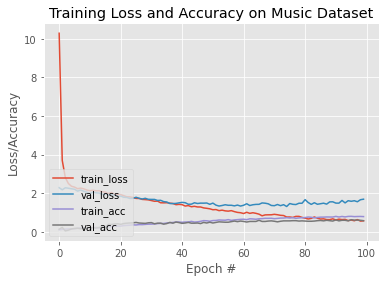

In [16]:
N = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Music Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")